In [1]:
import timm
import torch
import wandb
import fastai
import dill
import numpy as np
from fastai.callback.wandb import *
from fastai.vision.all import *
from fastai.vision.core import *
from fastai.text.core import RegexLabeller
from fastai.vision.utils import get_image_files
from fastai.data.block import DataBlock
from fastai.data.core import *
from fastai.tabular.all import *
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from huggingface_hub import notebook_login, push_to_hub_fastai, from_pretrained_fastai

In [2]:
config = SimpleNamespace(
    batch_size=32,  #16, #256,
    epochs=1,
    # learning_rate=2e-3,
    img_size=224,
    seed=42,
    pretrained=True,
    top_k_losses=5,
    model_name="maxvit_rmlp_small_rw_224.sw_in1k",# try with maxvit_nano_rw_256.sw_in1k # regnetx_040 coatnet_bn_0_rw_224.sw_in1k
    wandb_project="Ball_classifier", 
    wandb_group="ambrosia_symbiosis",
    job_type="training"
    )

In [3]:
def get_images(dataset_path, batch_size, img_size, seed):
    "The beetles dataset"
    files = get_image_files(path=dataset_path, recurse=True, folders=('train','valid'))
    dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                       get_items = get_image_files,
                       splitter = GrandparentSplitter(train_name='train', valid_name='valid'),
                       get_y = parent_label,
                       item_tfms = Resize(img_size, ResizeMethod.Pad, pad_mode='zeros'))
    dls = dblock.dataloaders(dataset_path, bs = batch_size)
    return dls

def train(config, dataset_path):
    "Train the model using the supplied config"
    dls = get_images(dataset_path=dataset_path, batch_size=config.batch_size, img_size=config.img_size, seed=config.seed)
    # wandb.init(project=config.wandb_project, group=config.wandb_group, job_type=config.job_type, config=config) # it is a good idea to keep these functions out of the training function due to some exporting issues
    cbs = [MixedPrecision(), ShowGraphCallback(), SaveModelCallback(), WandbCallback(log='gradients')] # (all, parameters, gradients or None) parameters and all does not work currently wandb needs to be updated
    learn = vision_learner(dls, 
                           config.model_name, 
                           loss_func=LabelSmoothingCrossEntropyFlat(),
                           metrics=[error_rate, 
                                    accuracy], 
                           cbs=cbs, 
                           pretrained=config.pretrained)
    learn.fine_tune(config.epochs)
    interp = ClassificationInterpretation.from_learner(learn)
    interp.plot_confusion_matrix()
    interp.plot_top_losses(config.top_k_losses, nrows=config.top_k_losses)
    # wandb.finish() # it is a good idea to keep these functions out of the training function due to some exporting issues
    return learn

wandb: Currently logged in as: christopher-marais. Use `wandb login --relogin` to force relogin


C:\Users\GCM\anaconda3\envs\BC_310\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.230209,0.207840,0.000280,0.999720,09:25


Better model found at epoch 0 with valid_loss value: 0.20784005522727966.


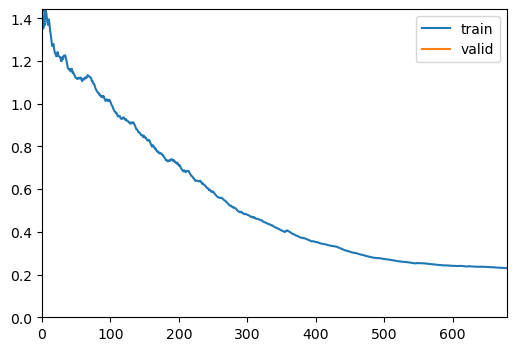

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.206542,0.199746,0.000187,0.999813,11:29


Better model found at epoch 0 with valid_loss value: 0.1997455209493637.


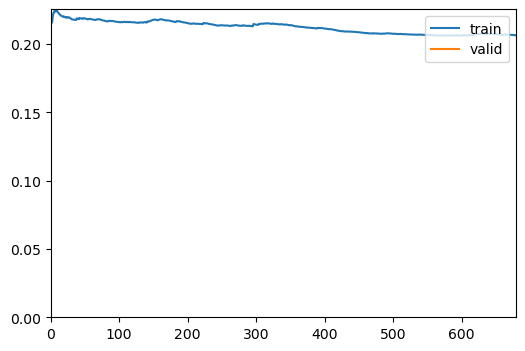

accuracy,▁█
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
error_rate,█▁
lr_0,▁▁▂▂▂▂▃▃▄▄▅▅▆▆▇▇████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▁▁▁▂▂▂▃▃▄▄▅▅▆▆▇▇████▂▂▂▃▄▄▄▄▄▄▄▃▃▃▂▂▂▁▁▁
mom_0,████▇▇▆▆▅▅▄▄▃▃▂▂▁▁▁▁█▇▆▄▂▁▁▁▁▂▂▃▄▅▆▆▇▇██
mom_1,████▇▇▆▆▅▅▄▄▃▃▂▂▁▁▁▁█▇▆▄▂▁▁▁▁▂▂▃▄▅▆▆▇▇██
raw_loss,█▇▇▅▆▇▄▃▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


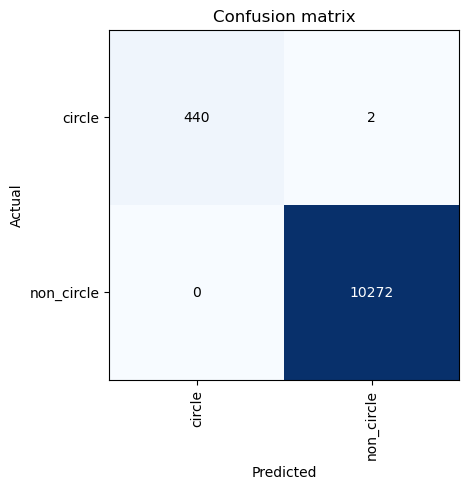

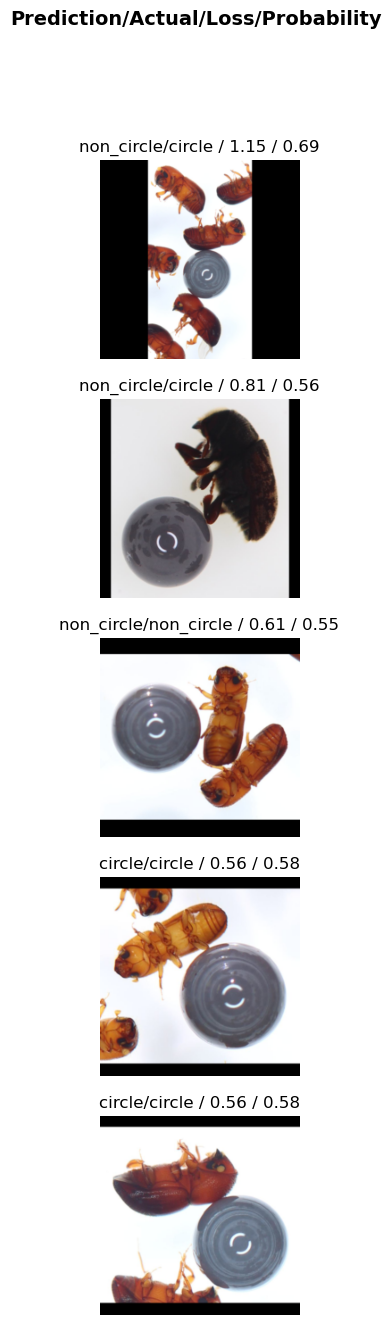

In [4]:
# Train Model
wandb.init(project=config.wandb_project, group=config.wandb_group, job_type=config.job_type, config=config)
learn = train(config=config, dataset_path=r"F:\segmented_circle_images")
wandb.finish()

In [10]:
# only save model locally
# save model to disk for inference
learn.path = Path(r"F:\ball_classifier\Models")
learn.remove_cb(WandbCallback) # remove WandbCallbacks to allow prediction model to be applied without wandb
# wandb.unwatch(learn.model)
learn.export('ball_classifier.pkl', pickle_module=dill)